In [1]:
from tqdm import tqdm
import pprint as pp
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import special_ortho_group
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import requests

#get device
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("GPU")
else:
    print("CPU")
    device = torch.device('cpu')

!mkdir models
#get files
files = ['X.bin','dX.bin','dynamicalsystems.py',]
for name in files:
    with requests.get('https://raw.githubusercontent.com/audrey163/Autoencoder/main/'+name, stream=True) as r:
        r.raise_for_status()
        with open(name, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                f.write(chunk)

from dynamicalsystems import SimplePendulum

CPU
mkdir: cannot create directory ‘models’: File exists


In [2]:
params = {
    'architecture' : { 
        'input_dimension' : 2,
        'latent_dimension' : 2 ,
        'SIND-y' : {}
    },
    'optimization' : { 
        'learn_rate' : 3e-4,
        'loss_reg' : {
            'X' : 1,
            'SINDy' : 1,
            'dX' : 1, #dX is regularization is 0 because dX_pred = None
            'Xi1' : 10,
            'Xi2' : 0,
            'zero-pole' : True #zero-pole is my custom loss function that uses |Xi|+1/|Xi| insted of |Xi| this adds a pole at zero when
        }
    },
    'training' : {
        'epochs' : 2000,
        'batch_size' : 2000,
        'save_freq' : 10,
        'load_weghts_from' : ':latest' # 'random.init', ':latest', None, 'models/FILENAME'
    },
    'inputs' : {
        'total_samples' : 2000,
    },
    'outputs' : {
        'loss' : True,
        'sindy_show' : False,
    },
    'sindy' : {
        'max_degree' : 2,
        'cross_terms' : True,
    }
}

dataset = SimplePendulum(g=9.8,l=2,mu=0.5,theta0=np.pi/2,time_steps=params['inputs']['total_samples'],embed_params={'embed_dim' : 2, 'mu' : 0,'sigma' : 0,'mu1' : 0,'sigma1' : 0,'mat' : 'RANDN'})
total_samples = len(dataset)

#X,dX = torch.Tensor(torch.load("X.bin").T), torch.Tensor(torch.load("dX.bin").T)
X,dX = torch.Tensor(dataset.X.T), torch.Tensor(dataset.dX.T) #GPU bug just going wo work with the values directoly not use torch.utils.data.Dataset inharitance

X.to(device)
dX.to(device)

tensor([[ 0.0000, -4.9000],
        [-0.0245, -4.8878],
        [-0.0489, -4.8755],
        ...,
        [-0.1801,  0.4895],
        [-0.1776,  0.4926],
        [-0.1751,  0.4957]])

In [3]:
class PolynomialLibrary:
    def __init__(self, max_degree=params['sindy']['max_degree'], cross_terms=params['sindy']['cross_terms']):
        self.max_degree = max_degree
        self.cross_terms = cross_terms
    def get_candidates(self, dim, feature_names):
        self.feature_names = feature_names
        return [self.__polynomial(degree_sequence) 
                    for degree in range(1,self.max_degree+1)
                        for degree_sequence in self.__get_degree_sequences(degree, dim)]
    def __polynomial(self, degree_sequence):
        def fn(X):
            terms = torch.stack( tuple(X[:,i]**d for i,d in enumerate(degree_sequence)), axis=1 )
            return torch.prod(terms, dim=1)
        fn_name = ' '.join(self.__display_term(self.feature_names[i],d) for i,d in enumerate(degree_sequence) if d)    
        return (fn, fn_name)   
    def __display_term(self, feature_name, d):
        if d == 1:
            return f'{feature_name}'
        return f'{feature_name}^{d}'
    def __get_degree_sequences(self, degree, num_terms):
        if num_terms == 1:  return [[degree]]
        if degree == 0:     return [[0 for _ in range(num_terms)]]
        res = []
        for d in reversed(range(degree+1)):
            for seq in self.__get_degree_sequences(degree-d, num_terms-1):
                res.append([d, *seq])
        return res
class TrigLibrary:
    def __init__(self):
        self.max_freq = 1
    def get_candidates(self, dim, feature_names):
        self.feature_names = feature_names
        return [trig(i) for trig in [self.__sin, self.__cos] for i in range(dim)]
    def __sin(self,i):
        fn = lambda X: torch.sin(X[:,i])
        fn_name = f'sin({self.feature_names[i]})'
        return (fn, fn_name)
    def __cos(self,i):
        fn = lambda X: torch.cos(X[:,i])
        fn_name = f'cos({self.feature_names[i]})'
        return (fn,fn_name)
class Theta:
    def __init__(self,):
        self.num_snapshots, self.num_features  = params['training']['batch_size'], params['architecture']['latent_dimension']
        self.feature_names = [f'x{i+1}' for i in range(self.num_features)]
        self.candidate_terms = [ lambda x: torch.ones(self.num_snapshots).to(device) ]
        self.candidate_names = ['1']
        self.libs = [ PolynomialLibrary(max_degree=1), TrigLibrary() ]
        for lib in self.libs:
            lib_candidates = lib.get_candidates(self.num_features, self.feature_names)
            for term, name in lib_candidates:
                self.candidate_terms.append(term)
                self.candidate_names.append(name)
    def theta(self,X):
         return torch.stack(tuple(f(X) for f in self.candidate_terms), axis=1).to(device)

In [4]:
theta = Theta()
theta.theta

<bound method Theta.theta of <__main__.Theta object at 0x7fea1036ec50>>

In [5]:
class FullSINDyAutoencoder(nn.Module):
    def __init__(self,params=None):
        super().__init__()
        self.params = params if params is not None else self.get_params()
        self.Theta = Theta()
        self.theta = Theta.theta
        self.encoder = nn.Sequential(
            nn.Linear(self.params['architecture']['input_dimension'], self.params['architecture']['latent_dimension'])
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.params['architecture']['latent_dimension'],self.params['architecture']['input_dimension'])
        )
        self.SINDy_layer = nn.Sequential(nn.Linear(len(self.Theta.candidate_terms),self.params['architecture']['latent_dimension'],bias=False))
        self.encoder.to(device)
        self.decoder.to(device)
        self.SINDy_layer.to(device)
    def forward(self, X, dX):
        Z = self.encoder(X.to(device)).to(device)
        return self.forward1(X,dX,Z)

    def forward1(self, X, dX,Z):
        X_pred = self.decoder(Z.to(device)).to(device)
        return self.forward2(X,dX,Z,X_pred)

    def forward2(self,X,dX,Z,X_pred):
        dZ = self.translate_derivative(X, dX, self.encoder)
        return self.forward3(X,dX,Z,X_pred,dZ)
    def forward3(self,X,dX,Z,X_pred,dZ):
        #now we must compute dZ pred
        dZ_pred = torch.matmul(theta.theta(Z.to(device)).to(device),self.SINDy_layer[0].weight.T.to(device)).to(device)#######################################################################
        # Xi is just sindy weights
        Xi = self.SINDy_layer[0].weight.to(device)
        return self.forward4(Z, X_pred, dZ, dZ_pred, Xi)
    def forward4(self,Z, X_pred, dZ, dZ_pred, Xi):
        dX_pred = self.translate_derivative(Z,dZ_pred,self.decoder).to(device)
        return Z, X_pred, dZ, dZ_pred, Xi, dX_pred
    def closure(self,X,dX,Z, X_pred, dZ, dZ_pred, Xi,dX_pred):
        Lx = torch.nn.functional.mse_loss(X.to(device),X_pred.to(device)).to(device) * self.params['optimization']['loss_reg']['X']
        Ly = torch.nn.functional.mse_loss(dZ,dZ_pred).to(device) * self.params['optimization']['loss_reg']['SINDy']
        Ldx = torch.nn.functional.mse_loss(dX,dX_pred).to(device) * self.params['optimization']['loss_reg']['dX']
        if self.params['optimization']['loss_reg']['zero-pole']:
            Li = self.never_zero_loss(Xi).to(device)
        else:
            Li = torch.abs(torch.sum(torch.abs(Xi)).to(device)-1)
        Li *= self.params['optimization']['loss_reg']['Xi1']
        return Lx.to(device) + Ly.to(device) + Li.to(device)
    def translate_derivative(self, X, X_dot, network):
        parameters = []
        for layer in network:
            if isinstance(layer, nn.Linear):
                parameters.append((layer.weight, layer.bias))
        l, dl = X, X_dot
        relu = nn.ReLU()
        for i, (w,b) in enumerate(parameters):
            l = l @ w.T + b
            dl = dl @ w.T
            if i < len(parameters) - 1:
                dl = (l > 0).float() * dl
                l = relu(l)
        return dl
    def train(self,dataset,dataloader,params=None):
        if params is not None:
            self.params = params
        optimizer = torch.optim.Adam(self.parameters(),lr=self.params['optimization']['learn_rate'])
        losses = []
        total_samples = len(dataset)
        n_iter = math.ceil(total_samples / self.params['training']['batch_size'])
        for epoch in range(self.params['training']['epochs']):
            print(f'Epoch {str(epoch)}')
            l = []
            for i, (X, dX) in enumerate(dataloader):
                X.to(device)
                dX.to(device)
                loss = self.closure(X,dX)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                l.append(loss.item())
            losses.append(np.mean(np.array(l)))
            print(loss.item())
        plt.plot(np.log(np.array(losses)))
        plt.title("log loss")
    def never_zero_loss(self,Xi):
        x = torch.sum(torch.abs(Xi))
        #this is aproximatly lim_x->infty (x-1/x)/x = (1+0)/1 = 1
        #also note that this is very simular to |x| its just that when |x| is small it becomes very large |0|+1/|0| = infinity
        return x + 1/x # the derivatative is 1-1/x^2 when x is far from zero this function is very cloase to x but when x is close to zero it becomes very large hence the optimization 
    def clip(self,epsilon):
        with torch.no_grad():
            self.SINDy_layer[0].weight.to(device)
            self.SINDy_layer[0].weight[torch.abs(self.SINDy_layer[0].weight) < epsilon] = 0.0
    def show(self):
        rows = torch.Tensor(self.SINDy_layer[0].weight).tolist()
        equations = [[round(coeff,7) for coeff in row] for row in rows]
        for i,eq in enumerate(equations):
            x = f'z{i+1}'
            rhs = ' + '.join(f'{coeff} {name}' for coeff, name in zip(eq, self.Theta.candidate_names))
            print(f'({x}.) = {rhs}.')   
    def get_params(self):
        import json
        with open('FullSINDyAutoencoder.conf') as json_file:
              return json.load(json_file)
    def save(self):
        import datetime
        timestamp = str(datetime.datetime.now())
        PATH = 'models/' + timestamp
        torch.save(self.state_dict(),PATH)
        print(f"Saved model to : {PATH}")

    def load(self,state_dict_PATH=None):
        if state_dict_PATH is not None:
            if state_dict_PATH == ':latest':
                from os import listdir
                from os.path import isfile, join
                onlyfiles = [f for f in listdir('models/') if isfile(join('models/', f))]
                onlyfiles.sort(reverse=True)
                state_dict_PATH = 'models/' + onlyfiles[0]
            self.load_state_dict(torch.load(state_dict_PATH))
            print(f"Using Model: {state_dict_PATH}")

In [6]:
X.to(device)
dX.to(device)
model = model = FullSINDyAutoencoder(params)
#model.load('models/2022-04-23 15:28:33.141130')
model.to(device)

FullSINDyAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
  )
  (SINDy_layer): Sequential(
    (0): Linear(in_features=7, out_features=2, bias=False)
  )
)

In [14]:
optimizer = torch.optim.Adam(model.parameters(),lr=params['optimization']['learn_rate'])
losses = []
for epoch in tqdm(range(params['training']['epochs'])):
    #print(f'Epoch {str(epoch)}')
    l = []
    Z, X_pred, dZ, dZ_pred, Xi, dX_pred = model.forward(X,dX)
    loss = model.closure(X,dX,Z, X_pred, dZ, dZ_pred, Xi,dX_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model.clip(1e-2)
    l.append(loss.item())
    losses.append(np.mean(np.array(l)))
#    print(loss.item())
#    if epoch % 5 == 0 and epoch > 0:
#        plt.plot(np.log(np.array(losses)))
#        plt.title("log loss")


100%|██████████| 2000/2000 [00:05<00:00, 340.34it/s]


In [13]:
model.save()

Saved model to : models/2022-04-25 13:59:27.887790


In [15]:
model.show()
Z = model.encoder(X)
Z.shape

(z1.) = 0.0 1 + 0.0 x1 + 0.0 x2 + 0.0 sin(x1) + 0.5922387 sin(x2) + 0.0 cos(x1) + 0.0 cos(x2).
(z2.) = 0.0 1 + -0.4113353 x1 + 0.0 x2 + 0.0 sin(x1) + 0.0 sin(x2) + 0.0 cos(x1) + 0.0 cos(x2).


torch.Size([2000, 2])

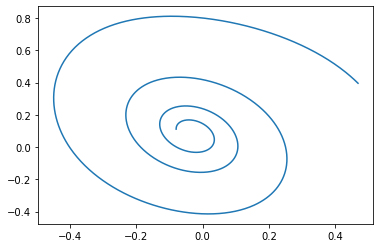

In [16]:
plt.plot(Z[:,1].detach().numpy(),Z[:,0].detach().numpy())